In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
class RNN(d2l.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)
    
    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [4]:
class RNNLM(d2l.RNNLMScratch):
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [5]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


'it has i                  '

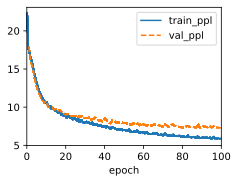

In [7]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [8]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has four in the perime '

In [12]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Model, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [16]:
input_size = 28
hidden_size = 128
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
model = RNN_Model(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, 28, 28)
        
        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    correct = 0
    total = 0
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.view(-1, 28, 28)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {100 * accuracy:.2f}%')


Epoch [1/10], Loss: 0.4182
Epoch [2/10], Loss: 0.1895
Epoch [3/10], Loss: 0.1428
Epoch [4/10], Loss: 0.2783
Epoch [5/10], Loss: 0.1714
Epoch [6/10], Loss: 0.0614
Epoch [7/10], Loss: 0.0302
Epoch [8/10], Loss: 0.0804
Epoch [9/10], Loss: 0.3305
Epoch [10/10], Loss: 0.0305
Test Accuracy: 94.44%


In [23]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            )
        self.fc = nn.Sequential(
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten before passing to fully connected layers
        x = self.fc(x)
        return x

In [25]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [27]:
num_epochs = 5
for epoch in range(num_epochs):
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluación del modelo en el conjunto de prueba
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_images, batch_labels in test_loader:
        outputs = model(batch_images)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {100 * accuracy:.2f}%')

Epoch [1/5], Loss: 0.0294
Epoch [2/5], Loss: 0.0091
Epoch [3/5], Loss: 0.0037
Epoch [4/5], Loss: 0.0028
Epoch [5/5], Loss: 0.0060
Test Accuracy: 98.79%
